In [ ]:
!pip install -q numpy pandas librosa matplotlib seaborn scikit-learn keras

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout,
                                     GlobalAveragePooling1D, Dense, Multiply, Reshape)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import tensorflow as tf
# from keras_focal_loss import categorical_focal_loss

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def custom_focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(true_labels, predicted_probs):
        eps = K.epsilon()
        predicted_probs = K.clip(predicted_probs, eps, 1.0 - eps)
        log_loss = -true_labels * K.log(predicted_probs)
        focal_factor = alpha * K.pow(1.0 - predicted_probs, gamma)
        focal_loss = focal_factor * log_loss
        return K.sum(focal_loss, axis=1)
    return loss_fn


In [ ]:
# --- Colab Specific: Mount Google Drive ---
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted.")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted.


In [ ]:
# Unzip Dataset
ZIP_SPEECH_PATH = '/content/drive/My Drive/mars_project/Audio_Speech_Actors_01-24.zip'
ZIP_SONG_PATH = '/content/drive/My Drive/mars_project/Audio_Song_Actors_01-24.zip'
EXTRACT_DIR = '/content/extracted_audio_data'
os.makedirs(EXTRACT_DIR, exist_ok=True)

!unzip -q "{ZIP_SPEECH_PATH}" -d "{EXTRACT_DIR}"
!unzip -q "{ZIP_SONG_PATH}" -d "{EXTRACT_DIR}"

In [ ]:
# Optimized Configuration
DATA_PATH = EXTRACT_DIR
emotion_dict = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust'}  # '08': 'surprised' excluded


In [ ]:
def process_directory(path):
    data = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                label = emotion_dict.get(file.split('-')[2])
                if label is not None:
                    data.append([file_path, label])  # Only store paths + labels
    return data

print("Collecting Speech Data...")
speech_data = process_directory(SPEECH_DIR)

print("Collecting Song Data...")
song_data = process_directory(SONG_DIR)

all_data = speech_data + song_data

Processing Speech Data...
Processing Song Data...


In [ ]:
# Generate features (no augmentation)
features = [[generate_features(fpath, apply_aug=False, emotion=label), label] for fpath, label in all_data]
df = pd.DataFrame(features, columns=['feature', 'emotion'])

In [ ]:
# -------------------------
# Create DataFrame
# -------------------------
df = pd.DataFrame(features, columns=['feature', 'emotion'])
# Remove "surprised" samples
df = df[df['emotion'] != 'surprised']
X = np.array([i for i in df['feature']])
y = np.array(df['emotion'].tolist())

In [ ]:
# -------------------------
# Encode + Scale
# -------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Scale
num_samples, time_steps, num_mfcc = X.shape
X_flat = X.reshape(num_samples * time_steps, num_mfcc)
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_flat)
X_scaled = X_scaled_flat.reshape(num_samples, time_steps, num_mfcc)

In [ ]:
# -------------------------
# Train Test Split
# -------------------------
X_train, X_test, y_train, y_test, train_paths, test_paths, y_train_labels = train_test_split(
    X_scaled, y_cat, [p[0] for p in all_data], y, test_size=0.2, stratify=y_cat, random_state=42
)

In [ ]:
# Augment training data
augmented_features = []
augmented_labels = []

for i, path in enumerate(train_paths):
    label = y_train_labels[i]
    aug_feat = generate_features(path, apply_aug=True, emotion=label)
    augmented_features.append(aug_feat)
    augmented_labels.append(label)

# Convert augmented data
aug_X = np.array(augmented_features)
aug_y = le.transform(augmented_labels)
aug_y_cat = to_categorical(aug_y)

# Scale augmented data
num_aug_samples = aug_X.shape[0]
aug_X_flat = aug_X.reshape(num_aug_samples * time_steps, num_mfcc)
aug_X_scaled_flat = scaler.transform(aug_X_flat)
aug_X_scaled = aug_X_scaled_flat.reshape(num_aug_samples, time_steps, num_mfcc)

# Concatenate with training set
X_train_final = np.concatenate([X_train, aug_X_scaled], axis=0)
y_train_final = np.concatenate([y_train, aug_y_cat], axis=0)


In [ ]:
# -------------------------
# Balanced Class Weight Computation
# -------------------------
from sklearn.utils.class_weight import compute_class_weight

# Prepare label array
labels_train = np.argmax(y_train, axis=1)
unique_labels = np.unique(labels_train)

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=labels_train)
weight_map = dict(zip(unique_labels, weights))

In [ ]:
# -------------------------
# SE Block
# -------------------------
from tensorflow.keras.layers import GlobalAveragePooling1D, Multiply, Dense

def SE_Block(input_tensor, reduction_ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, filters))(se)
    return Multiply()([input_tensor, se])

In [ ]:
# -------------------------
# Final Model with SE Blocks
# -------------------------
num_classes = y_cat.shape[1]
input_shape = X_train.shape[1:]

inp = Input(shape=input_shape)

x = Conv1D(64, kernel_size=5, padding='same', activation='relu')(inp)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = SE_Block(x)

x = Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = SE_Block(x)

x = Conv1D(256, kernel_size=5, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = SE_Block(x)

x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)
model.compile(loss=custom_focal_loss(gamma=2),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 130, 60)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 130, 64)        │         19,264 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 130, 64)        │            256 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 65, 64)         │              0 │ batch_normalization_3… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 65, 64)         │              0 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ dropout_4[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │            320 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 1, 64)          │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_3 (Multiply)     │ (None, 65, 64)         │              0 │ dropout_4[0][0],       │
│                           │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 65, 128)        │         41,088 │ multiply_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 65, 128)        │            512 │ conv1d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 32, 128)        │              0 │ batch_normalization_4… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 32, 128)        │              0 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ dropout_5[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)     

 Total params: 305,059 (1.16 MB)

 Trainable params: 304,163 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# -------------------------
# Model Training Setup
# -------------------------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Custom Callbacks
stop_early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

# Model Fitting
training_log = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=100,
    callbacks=[stop_early, lr_scheduler],
    class_weight=weight_map,  # match your new variable from previous cell
    verbose=1
)


Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.3091 - loss: 0.3073 - val_accuracy: 0.4132 - val_loss: 0.2625 - learning_rate: 1.0000e-04
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.5459 - loss: 0.1791 - val_accuracy: 0.6261 - val_loss: 0.1560 - learning_rate: 1.0000e-04
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.6215 - loss: 0.1408 - val_accuracy: 0.6720 - val_loss: 0.1218 - learning_rate: 1.0000e-04
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.6604 - loss: 0.1205 - val_accuracy: 0.7146 - val_loss: 0.1062 - learning_rate: 1.0000e-04
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.6985 - loss: 0.1036 - val_accuracy: 0.7373 - val_loss: 0.0943 - learning_rate: 1.0000e-04
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.7219 - loss: 0.0937 - val_accuracy: 0.7528 - val_loss: 0.0856 - learning_rate: 1.0000e-04
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 9

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# ⬇️ Generate predictions
pred_probs = model.predict(X_test)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(y_test, axis=1)

# ✅ Overall Accuracy
acc_total = accuracy_score(true_labels, pred_labels)
print(f"\n✅ Overall Accuracy: {acc_total * 100:.2f}%")

# ✅ Macro-averaged F1 Score
macro_f1 = f1_score(true_labels, pred_labels, average='macro')
print(f"✅ F1 Score (Macro): {macro_f1 * 100:.2f}%")

# ✅ Per-Class Accuracy Calculation
conf_mat = confusion_matrix(true_labels, pred_labels)
acc_per_class = conf_mat.diagonal() / conf_mat.sum(axis=1)
print("\n✅ Accuracy per Emotion Class:")
for emotion, score in zip(le.classes_, acc_per_class):
    print(f"{emotion}: {score * 100:.2f}%")

# ✅ Detailed Report
print("\nClassification Metrics Report:")
print(classification_report(true_labels, pred_labels, target_names=le.classes_))

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

✅ Overall Accuracy: 94.30%
✅ F1 Score (Macro): 94.66%

✅ Accuracy per Emotion Class:
angry: 96.01%
calm: 99.00%
disgust: 100.00%
fearful: 97.34%
happy: 81.40%
neutral: 100.00%
sad: 92.03%

Classification Metrics Report:
              precision    recall  f1-score   support

       angry       0.99      0.96      0.98       301
        calm       0.97      0.99      0.98       301
     disgust       0.91      1.00      0.95       153
     fearful       0.87      0.97      0.92       301
       happy       0.97      0.81      0.89       301
     neutral       0.99      1.00      0.99       150
         sad       0.92      0.92      0.92       301

    accuracy                           0.94      1808
   macro avg       0.95      0.95      0.95      1808
weighted avg       0.95      0.94      0.94      1808



In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9453 - loss: 0.0153
Test Accuracy: 94.30%


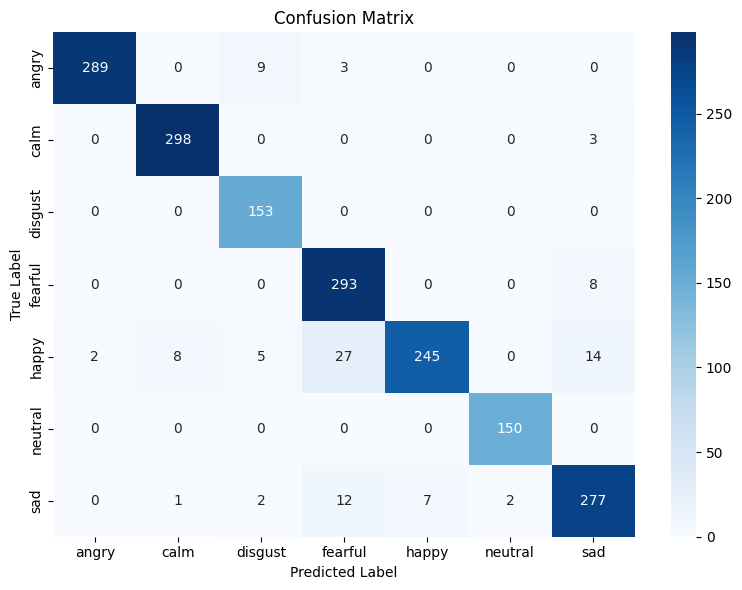

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


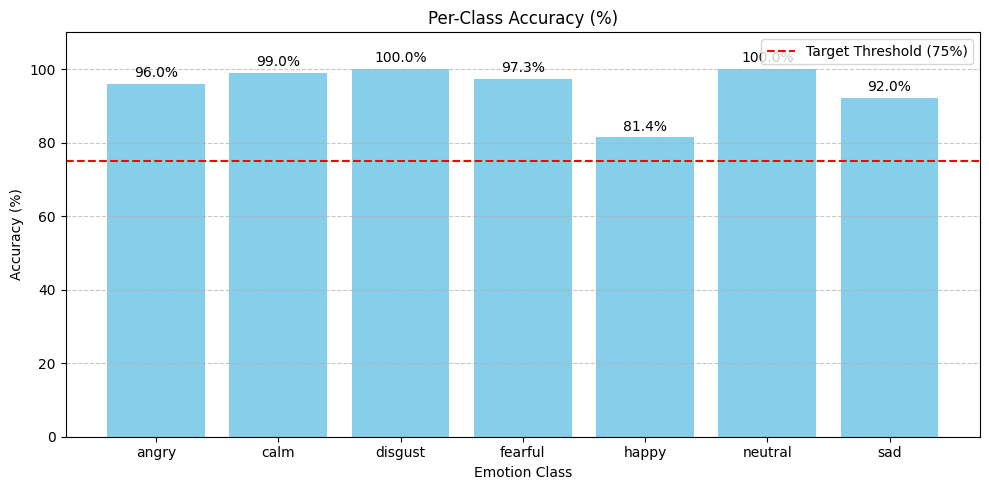

In [ ]:
# Bar chart for per-class accuracy
plt.figure(figsize=(10, 5))
bars = plt.bar(le.classes_, acc_per_class * 100, color='skyblue')
plt.axhline(y=75, color='r', linestyle='--', label='Target Threshold (75%)')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)

plt.title("Per-Class Accuracy (%)")
plt.ylabel("Accuracy (%)")
plt.xlabel("Emotion Class")
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Save Model and Scaler

model.save('emotion_model.h5')
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)